In [1]:
!pip install plotly
!pip install -U kaleido

In [2]:
import pandas as pn
from datetime import datetime
import plotly.express as px
import numpy as np

In [3]:
Data = pn.read_csv("../../../data/stage_1/Employment_Data_Annual_2020.csv")
Deaths = pn.read_csv("../../../data/stage_1/covid_deaths_usafacts.csv")
Cases = pn.read_csv("../../../data/stage_1/covid_confirmed_usafacts.csv")
Population = pn.read_csv("../../../data/stage_1/covid_county_population_usafacts.csv")

/Users/chandu/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### Removing all the data that containes 'Statewide Unallocated' as County Name. Dropping County Name column from population to make dataset ready to merge.

In [4]:
Deaths = Deaths[Deaths['County Name'] != 'Statewide Unallocated']
Cases = Cases[Cases['County Name'] != 'Statewide Unallocated']
Population = Population[Population['County Name'] != 'Statewide Unallocated']
Population = Population.drop(columns = ['County Name'])

Merging Death and Population Datasets. The merge Dataset is converted to long format.

In [5]:
Death_Population = pn.merge(Deaths, Population, on = ['countyFIPS', 'State'])
Death_Population_long = pn.melt(Death_Population,id_vars=['countyFIPS','State','County Name','StateFIPS','population'],
             var_name='Date', value_name='Deaths')

Cases dataset is converted to long format and merged with the Death_Population_long dataset.

In [6]:
Cases_long = pn.melt(Cases,id_vars=['countyFIPS','State','County Name','StateFIPS'], var_name='Date', value_name='Cases')

In [7]:
merge_dcp_long = pn.merge(Death_Population_long,Cases_long, on=['countyFIPS','State','County Name','StateFIPS', 'Date'])

Saving the dataset to .csv file.

In [8]:
merge_dcp_long.to_csv("../../../data/stage_2/superset_long.csv",index=False)

Converting Date column to Date datatype and fill the NaN with zero '0'. The data is stored in new DataFrame 'updated'.

In [9]:
date = pn.DataFrame(pn.to_datetime(merge_dcp_long['Date']))
no_date = pn.DataFrame(merge_dcp_long.drop(columns=['Date']))
updated = pn.concat([date.reset_index(drop=True),no_date.reset_index(drop=True)], axis=1).fillna(0)

In [10]:
updated = updated.sort_values(by=['countyFIPS', 'Date'])

Finding new cases per day by applying diff() on Cases and Deaths columns grouped for each county.

In [11]:
updated['New_Cases_Per_Day'] = updated.groupby('countyFIPS').Cases.diff()
updated['New_Deaths_Per_Day'] = updated.groupby('countyFIPS').Deaths.diff()

#### Average number of new cases per each week are calculated for each county by finding mean of all the new cases of that county in that week.

In [12]:
weeklyData = updated.groupby([ pn.Grouper(key='Date', freq='1w'),'countyFIPS'])['New_Cases_Per_Day','New_Deaths_Per_Day'].agg({'New_Cases_Per_Day':'mean',
                                                                                                'New_Deaths_Per_Day' :'mean'}).reset_index().round(decimals=0)


<ipython-input-12-b2174ec83ae3>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  weeklyData = updated.groupby([ pn.Grouper(key='Date', freq='1w'),'countyFIPS'])['New_Cases_Per_Day','New_Deaths_Per_Day'].agg({'New_Cases_Per_Day':'mean',


#### Mean, Median and Mode of weekly new cases and new deaths through out United States.

In [13]:
week_cases_mean = weeklyData['New_Cases_Per_Day'].mean()
week_cases_median = weeklyData['New_Cases_Per_Day'].median()
week_cases_mode = weeklyData['New_Cases_Per_Day'].mode()

print('Weekly Cases Mean: ', week_cases_mean)
print('Weekly Cases Median: ', week_cases_median)
print('Weekly Cases Mode: ', week_cases_mode)

Weekly Cases Mean:  20.484638745944952
Weekly Cases Median:  2.0
Weekly Cases Mode:  0    0.0
dtype: float64


In [14]:
week_deaths_mean = weeklyData['New_Deaths_Per_Day'].mean()
week_deaths_median = weeklyData['New_Deaths_Per_Day'].median()
week_deaths_mode = weeklyData['New_Deaths_Per_Day'].mode()

print('Weekly Deaths Mean: ', week_deaths_mean)
print('Weekly Deaths Median: ', week_deaths_median)
print('Weekly Deaths Mode: ', week_deaths_mode)

Weekly Deaths Mean:  0.3004379069428574
Weekly Deaths Median:  0.0
Weekly Deaths Mode:  0    0.0
dtype: float64


# Countries with similar population to USA are Indonesia, Pakistan, Brazil, Nigeria and Bangladesh.

In [15]:
owid_df = pn.read_csv("../../../data/stage_2/owid-covid-data.csv")

Considering United States to maintain the consistancy in the data(latest Data as per single source).

In [16]:
owid_df = owid_df[owid_df['location'].isin(['Indonesia', 'Pakistan', 'Brazil', 'Nigeria', 'Bangladesh', 'United States'])]

Converting date column into date datatype and considering the available columns of cases and deths per million population from the dataset.

In [17]:
owid_date = pn.DataFrame(pn.to_datetime(owid_df['date']))
owid_df = pn.DataFrame(owid_df.drop(columns=['date']))
owid_df = pn.concat([owid_date.reset_index(drop=True),owid_df.reset_index(drop=True)], axis=1).fillna(0)
owid_df = owid_df[['date', 'iso_code', 'location', 'new_cases_per_million', 'new_deaths_per_million']]
owid_df

,date,iso_code,location,new_cases_per_million,new_deaths_per_million
0,2020-03-03,BGD,Bangladesh,0.000,0.000
1,2020-03-04,BGD,Bangladesh,0.000,0.000
2,2020-03-05,BGD,Bangladesh,0.000,0.000
3,2020-03-06,BGD,Bangladesh,0.000,0.000
4,2020-03-07,BGD,Bangladesh,0.000,0.000
...,...,...,...,...,...
3672,2021-10-22,USA,United States,298.641,5.467
3673,2021-10-23,USA,United States,81.096,1.283
3674,2021-10-24,USA,United States,50.451,0.424
3675,2021-10-25,USA,United States,309.082,4.208


#### Graph of daily new cases per million population.

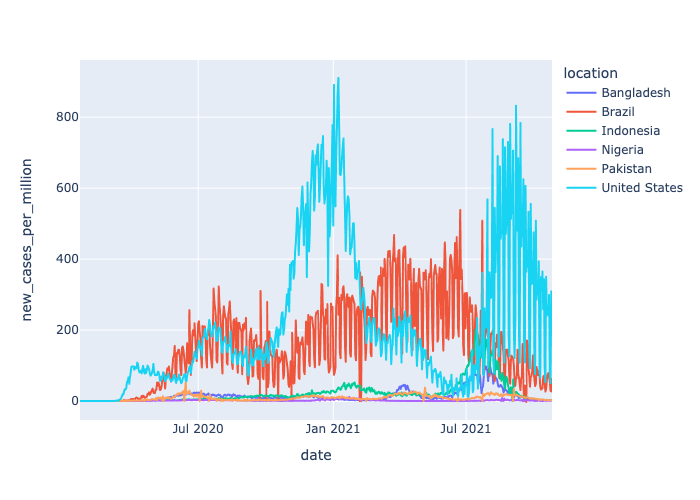

In [18]:
cases_plot = px.line(owid_df, x ='date', y='new_cases_per_million', color='location')
cases_plot.show("png")

#### Graph of daily new deaths per million population.

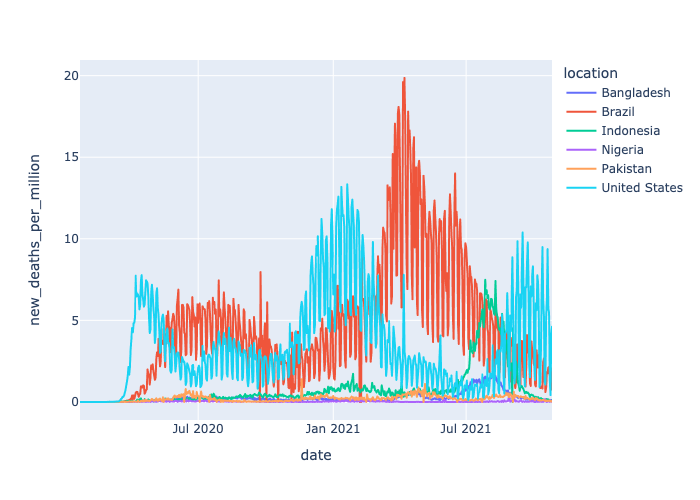

In [19]:
deaths_plot = px.line(owid_df, x ='date', y='new_deaths_per_million', color='location')
deaths_plot.show("png")

#### Finding average new cases and deaths per million per week for United States and other countries.

In [20]:
owid_df_weeklyData = owid_df.groupby([ pn.Grouper(key='date', freq='1w'),'location'])['new_cases_per_million','new_deaths_per_million'].agg({'new_cases_per_million':'mean',
                                                                                                'new_deaths_per_million' :'mean'}).reset_index().round(decimals=0)

owid_df_weeklyData

<ipython-input-20-ecd8936dc910>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,date,location,new_cases_per_million,new_deaths_per_million
0,2020-01-26,United States,0.0,0.0
1,2020-02-02,United States,0.0,0.0
2,2020-02-09,United States,0.0,0.0
3,2020-02-16,United States,0.0,0.0
4,2020-02-23,United States,0.0,0.0
...,...,...,...,...
526,2021-10-31,Brazil,45.0,1.0
527,2021-10-31,Indonesia,2.0,0.0
528,2021-10-31,Nigeria,2.0,0.0
529,2021-10-31,Pakistan,2.0,0.0


### Finding peak week of the cases and deaths in US and other countries.

In [21]:
global_df = pn.DataFrame(columns=('location', 'Max_new_cases_in_a_week_per_million', 'Max_cases_Week_start_date', 
                                  'Max_new_deaths_in_a_week_per_million', 'Max_deaths_Week_start_date'))

In [22]:
for i in owid_df_weeklyData['location'].unique():
    max_cases = owid_df_weeklyData[owid_df_weeklyData['location'] == i]['new_cases_per_million'].max()
    max_deaths = owid_df_weeklyData[owid_df_weeklyData['location'] == i]['new_deaths_per_million'].max()
    case_date = owid_df_weeklyData[(owid_df_weeklyData['location'] == i) & (owid_df_weeklyData['new_cases_per_million']==max_cases)]['date']
    death_date = owid_df_weeklyData[(owid_df_weeklyData['location'] == i) & (owid_df_weeklyData['new_deaths_per_million']==max_deaths)]['date']
    data = {'location':i, 
            'Max_new_cases_in_a_week_per_million' : max_cases, 'Max_cases_Week_start_date' : np.array(case_date) ,
            'Max_new_deaths_in_a_week_per_million' : max_deaths, 'Max_deaths_Week_start_date' : np.array(death_date)}
    global_df = global_df.append(data,ignore_index=True)

In [23]:
global_df['New_Max_cases_Week_start_date'] = global_df['Max_cases_Week_start_date'].astype(str)
global_df['New_Max_deaths_Week_start_date'] = global_df['Max_deaths_Week_start_date'].astype(str)

global_df = global_df.drop(columns=['Max_deaths_Week_start_date','Max_cases_Week_start_date'])

global_df['New_Max_deaths_Week_start_date'] = global_df['New_Max_deaths_Week_start_date'].str[2:12]
global_df['New_Max_cases_Week_start_date'] = global_df['New_Max_cases_Week_start_date'].str[2:12]

In [24]:
global_df

,location,Max_new_cases_in_a_week_per_million,Max_new_deaths_in_a_week_per_million,New_Max_cases_Week_start_date,New_Max_deaths_Week_start_date
0,United States,744.0,10.0,2021-01-10,2021-01-10
1,Brazil,358.0,14.0,2021-03-28,2021-04-11
2,Nigeria,8.0,0.0,2021-01-24,2020-03-01
3,Pakistan,26.0,1.0,2020-06-14,2020-06-21
4,Bangladesh,86.0,1.0,2021-08-01,2021-04-18
5,Indonesia,181.0,6.0,2021-07-18,2021-08-01
